# 📊 Backtesting Machine Learning Trading Strategies

## Introduction

This notebook explores **backtesting Machine Learning-based trading strategies**, focusing on computationally efficient yet effective approaches, such as **Random Forest**. The goal is to evaluate the performance of these strategies using historical market data.

As with other experiments in this repository, we will leverage **Mini_lib** to facilitate key steps in applying ML to financial data. Specifically, we will:  

1. **Label the data** – Define the target variable for our ML model.  
2. **Generate and analyze features** – Extract meaningful financial indicators.  
3. **Train a model** – Use ML techniques, such as Random Forest, to derive trading signals.  
4. **Implement a strategy** – Convert model predictions into actionable trading rules.  
5. **Backtest the strategy** – Assess its performance using a robust backtesting framework.  

By following this structured approach, we aim to determine the viability of ML-driven trading strategies in real market conditions.

In [2]:
import sys
sys.path.append("..")
import Data as dt
import Mini_lib as lib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## **I. Getting Data and Making Samples**  

The first step in our workflow is to **acquire and preprocess market data**. This involves:  

1. **Fetching historical price data** – Using reliable sources to obtain asset prices.  
2. **Cleaning and preprocessing** – Handling missing values, adjusting for corporate actions, and ensuring consistency.  
   *(Note: The dataset used here is already processed, so we will skip this step.)*  
3. **Creating research samples** – Splitting the data into **Training**, **Testing**, and **Embargo** sets to prevent overfitting.  

### ⚠️ **Important Note**  
A **testing set** should be used **sparingly**! It is recommended to track the number of times it is accessed to prevent data leakage and ensure unbiased model evaluation.  


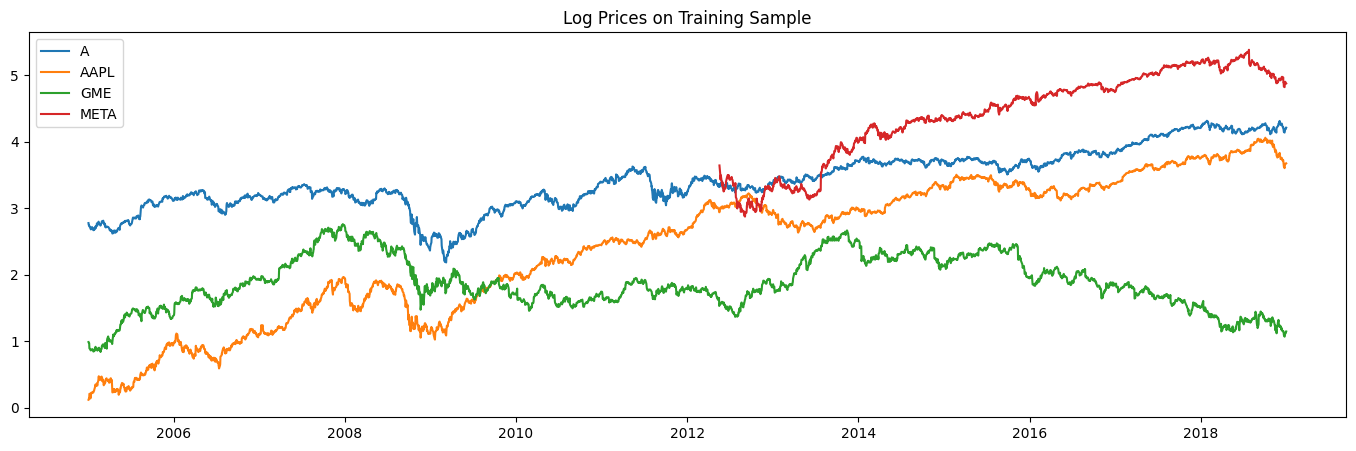

In [3]:
# I. Load data
data = dt.load_dataList(ticker_list=['A', 'AAPL', 'GME', 'META'])

# II. Making Samples
training_data = {}
testing_data = {}
embargo_data = {}

for ticker in data.keys():
    full_df = data[ticker]
    training_data[ticker] = full_df.loc['2005-01-01':'2019-01-01']
    testing_data[ticker] = full_df.loc['2019-01-01': '2023-01-01']
    embargo_data[ticker] = full_df.loc['2023-01-01':]

# III. Let's see the training data we have on a log scale
plt.figure(figsize=(17, 5))
for asset_df in training_data.values():
    plt.plot(np.log(asset_df['close']), label=asset_df['code'].iloc[0])
plt.legend()
plt.title('Log Prices on Training Sample')
plt.show()

## Correlation Matrices Over Time

To analyze how relationships between our selected assets evolve, we will compute correlation matrices at different time intervals. This will help us identify trends, shifts in dependencies, and potential changes in market dynamics over time.


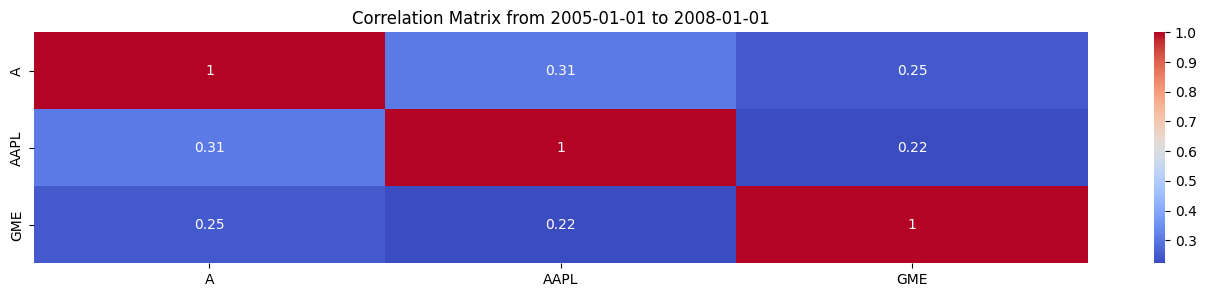

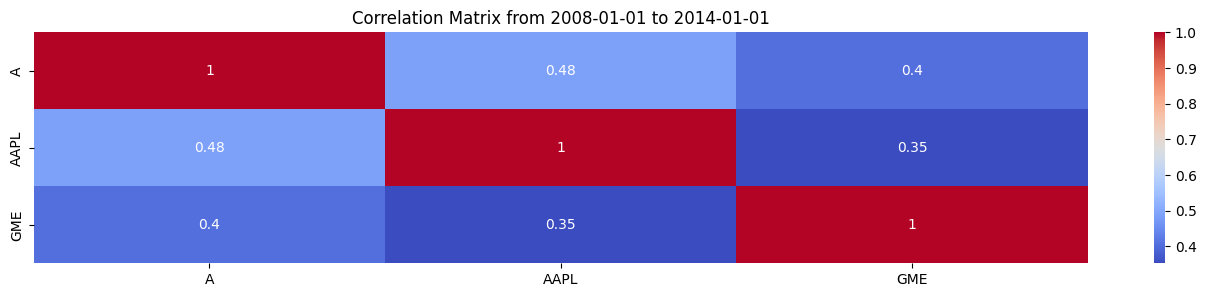

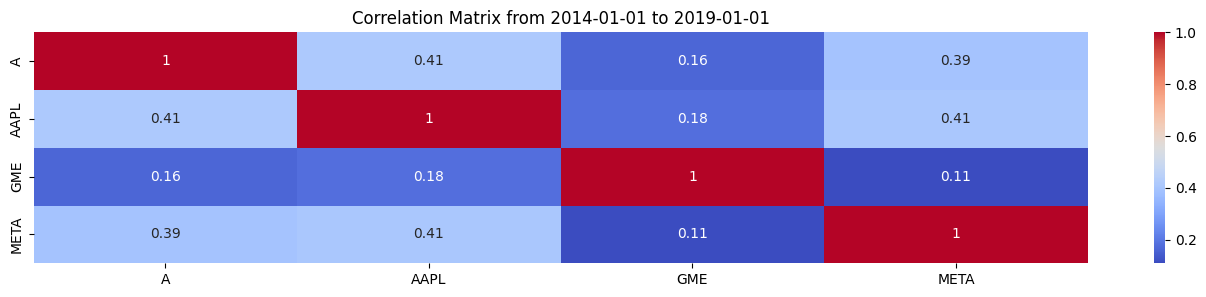

In [4]:
close_df = pd.DataFrame({ticker: asset_df['close'] for ticker, asset_df in training_data.items()})
returns_df = np.log(close_df).diff()
returns_df = returns_df.dropna()

dates_checkpoint = ['2005-01-01', '2008-01-01', '2014-01-01', '2019-01-01']
for idx in range(1, len(dates_checkpoint)):
    date = dates_checkpoint[idx]
    previous_date = dates_checkpoint[idx - 1]

    close_df = pd.DataFrame({ticker: asset_df['close'].loc[previous_date:date] for ticker, asset_df in training_data.items()})
    close_df = close_df.dropna(axis=1)
    returns_df = np.log(close_df).diff()
    returns_df = returns_df.dropna()

    correlation_matrix = returns_df.corr()
    plt.figure(figsize=(17, 3))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix from {previous_date} to {date}')
    plt.show()

### **🔍 Training Set Overview**

Our training dataset consists of **four assets**: `GME`, `META`, `AAPL`, and `A`, spanning from **2005 to 2019**. These assets exhibit distinct price behaviors over time:  

- **AAPL & META** – Consistent strong upward movement.  
- **GME** – Varied performance with shifting market conditions.  
- **A** –  Long term upward movement after a flat period.

One key observation is that **the correlation between these assets changes over time**. This is beneficial for our ML experiment as it provides:  

✅ **Diverse market regimes** – Ensuring the model learns from different conditions.  
✅ **Generalization ability** – Training across different asset behaviors without conflicting signals.  
✅ **Robustness** – Avoiding overfitting to a single asset's characteristics.  

---
## **II. Labelling Data**  

To train our classification models, we need to **define a labeling method** that captures meaningful patterns in price movements.  

### 🎯 **Objective**  
The goal is to assign labels to our dataset that reflect future market conditions, allowing our ML models to learn predictive patterns.  

### 🏷️ **Labeling Approach**  
We apply a **labeling method** to categorize market states based on price behavior. This step is crucial because:  

✅ It transforms raw price data into a structured learning problem.  
✅ It helps the model differentiate between profitable and unprofitable conditions.  
✅ It avoids bias by ensuring well-balanced class distributions.  

In [5]:
# II. Apply the labellers : for each labeller class, you can change the parameters in the dictionary and the labels will be computed for each parameter set.
#    The labels are stored in the dataframe with the name of the labeller class and the parameter set as a suffix.
tripleBarrier_params = {
    "upper_barrier": [1],
    "lower_barrier": [2],
    "vertical_barrier": [20],
    "window": [20],
    "smoothing_method": [None],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}
lookForward_params = {
    "window_lookForward": [10],
    "min_trend_size": [5],
    "volatility_threshold": [1],
    "smoothing_method": ["ewma"],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}

for ticker, asset_df in training_data.items():
    df = asset_df.copy()
    close_series = df['close']

    # Initialize the labellers with the parameters
    tripleBarrier_labeller = lib.tripleBarrier_labeller(data=close_series, params=tripleBarrier_params, n_jobs=1)
    lookForward_labeller = lib.lookForward_labeller(data=close_series, params=lookForward_params, n_jobs=1)
    
    # Extract the labels, here we only use the first set of parameters for each labeller
    labels_df_tb = tripleBarrier_labeller.extract()
    labels_df_lf = lookForward_labeller.extract()

    df.loc[:, 'labels_tb'] = labels_df_tb['set_0']
    df.loc[:, 'labels_lf'] = labels_df_lf['set_0']

    training_data[ticker] = df

for ticker, asset_df in testing_data.items():
    df = asset_df.copy()
    close_series = df['close']

    # Initialize the labellers with the parameters
    tripleBarrier_labeller = lib.tripleBarrier_labeller(data=close_series, params=tripleBarrier_params, n_jobs=1)
    lookForward_labeller = lib.lookForward_labeller(data=close_series, params=lookForward_params, n_jobs=1)
    
    # Extract the labels, here we only use the first set of parameters for each labeller
    labels_df_tb = tripleBarrier_labeller.extract()
    labels_df_lf = lookForward_labeller.extract()

    df.loc[:, 'labels_tb'] = labels_df_tb['set_0']
    df.loc[:, 'labels_lf'] = labels_df_lf['set_0']

    testing_data[ticker] = df

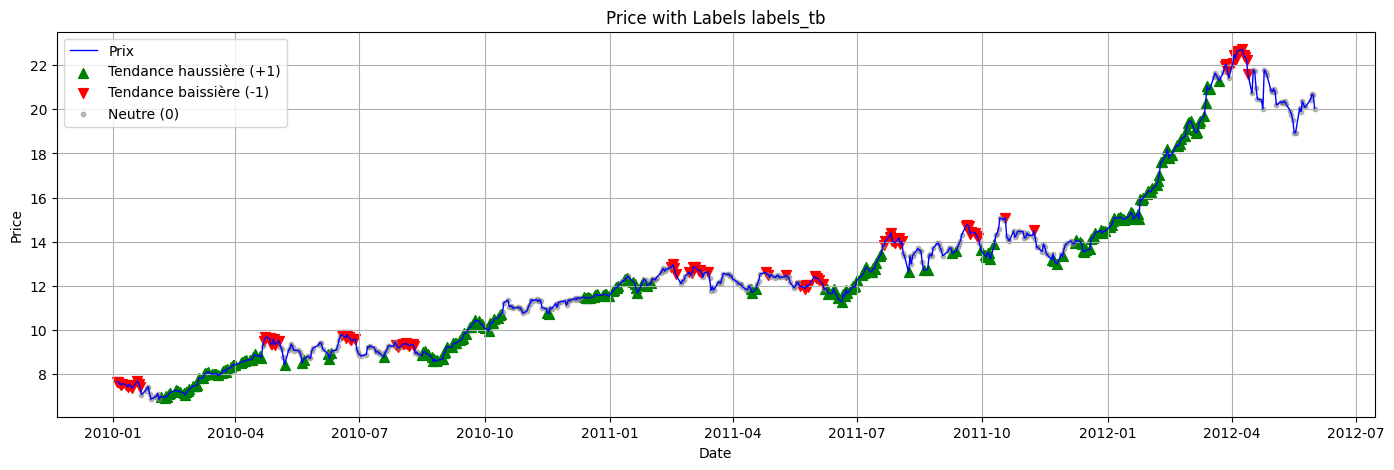

labels_tb
 0.0    265
 1.0    249
-1.0     95
Name: count, dtype: int64


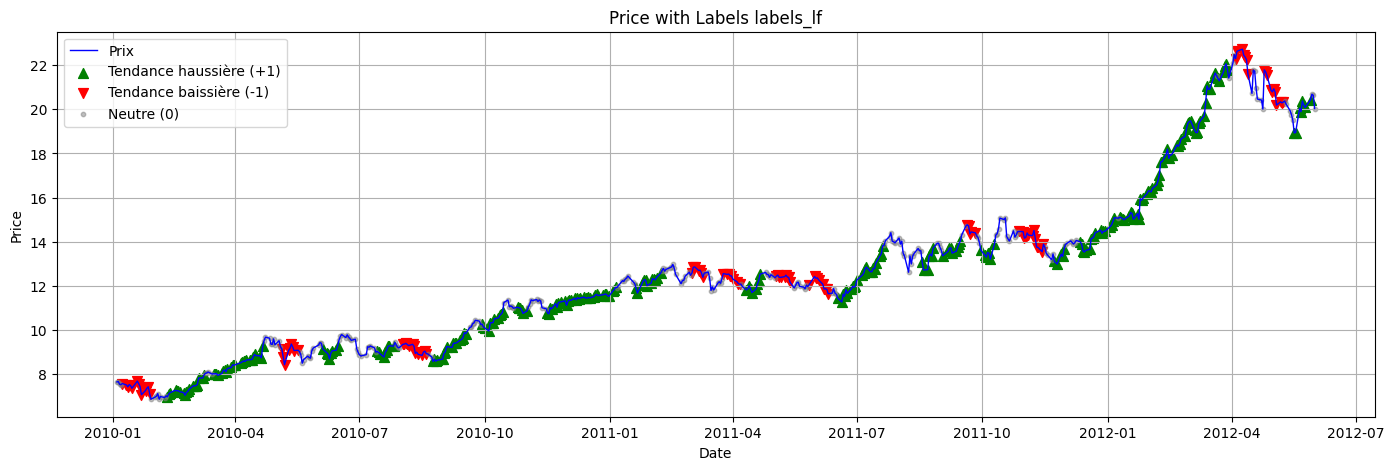

labels_lf
 1.0    287
 0.0    214
-1.0    108
Name: count, dtype: int64


In [6]:
# III. Plot some labels to see the differences
price_series = training_data['AAPL']['close'].loc['2010-01-01':'2012-06-01']
labels_tb = training_data['AAPL']['labels_tb'].loc['2010-01-01':'2012-06-01']
labels_lf = training_data['AAPL']['labels_lf'].loc['2010-01-01':'2012-06-01']

lib.plot_price_with_labels(price_series, labels_tb)
print(labels_tb.value_counts())

lib.plot_price_with_labels(price_series, labels_lf)
print(labels_lf.value_counts())

---
## **III. Feature Exploration**  

In this section, we will **generate and analyze features** to determine if they contain meaningful information for our model.  

### 🔍 **Objective**  
The goal is to create financial indicators that help distinguish different market conditions and improve model predictions.  

### ⚙️ **Feature Engineering Process**  
We will:  
1. **Generate features** – Extract technical, statistical, and market-based indicators.  
2. **Analyze their distributions** – Check for patterns and potential predictive power.  
3. **Assess feature importance** – Determine which features contribute the most to classification.  

In [7]:
# I. Create some features
params_general = {
    "window": [5, 10, 30, 60, 120],
    "smoothing_method": [None, "ewma"],
    "window_smooth": [10],
    "lambda_smooth": [0.2],
}

# Adapt the parameters for the specific features : Quantile & Hurst Exponent
params_quantile = params_general.copy()
params_quantile["quantile"] = [0.1, 0.9]

params_hurst = params_general.copy()
del params_hurst["window"]
params_hurst["power"] = [3, 4, 5]

# Extract features for each asset in the training data
label_features_training = {}
for ticker, asset_df in tqdm(training_data.items()):
    asset_df = asset_df.copy() 
    close_series = asset_df['close']
    
    average_features = lib.average_feature(data=close_series, params=params_general, n_jobs=9).extract()
    minimum_features = lib.minimum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    volatility_features = lib.volatility_feature(data=close_series, params=params_general, n_jobs=9).extract()
    quantile_features = lib.quantile_feature(data=close_series, params=params_quantile, n_jobs=9).extract()
    Z_momentum_features = lib.Z_momentum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    nonlinear_tempreg_features = lib.nonlinear_tempReg_feature(data=close_series, params=params_general, n_jobs=9).extract()
    hurst_exponent_features = lib.hurst_exponent_feature(data=close_series, params=params_hurst, n_jobs=9).extract()

    feature_df = pd.concat([average_features, minimum_features, volatility_features, quantile_features, Z_momentum_features, nonlinear_tempreg_features, hurst_exponent_features], axis=1)
    label_feature_df = pd.concat([feature_df, asset_df[['labels_tb', 'labels_lf']]], axis=1)
    label_features_training[ticker] = label_feature_df

# Also prepare the features for the testing data
label_features_testing = {}
for ticker, asset_df in tqdm(testing_data.items()):
    asset_df = asset_df.copy() 
    close_series = asset_df['close']
    
    average_features = lib.average_feature(data=close_series, params=params_general, n_jobs=9).extract()
    minimum_features = lib.minimum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    volatility_features = lib.volatility_feature(data=close_series, params=params_general, n_jobs=9).extract()
    quantile_features = lib.quantile_feature(data=close_series, params=params_quantile, n_jobs=9).extract()
    Z_momentum_features = lib.Z_momentum_feature(data=close_series, params=params_general, n_jobs=9).extract()
    nonlinear_tempreg_features = lib.nonlinear_tempReg_feature(data=close_series, params=params_general, n_jobs=9).extract()
    hurst_exponent_features = lib.hurst_exponent_feature(data=close_series, params=params_hurst, n_jobs=9).extract()

    feature_df = pd.concat([average_features, minimum_features, volatility_features, quantile_features, Z_momentum_features, nonlinear_tempreg_features, hurst_exponent_features], axis=1)
    label_feature_df = pd.concat([feature_df, asset_df[['labels_tb', 'labels_lf']]], axis=1)
    label_features_testing[ticker] = label_feature_df

  0%|          | 0/4 [00:00<?, ?it/s]/home/mathis/Code/QuantExperiments/notebooks/../Mini_lib/Models/common.py:84: RuntimeWarning: divide by zero encountered in divide
  t_stats = coefficients / se_coefficients
 75%|███████▌  | 3/4 [03:25<01:06, 66.28s/it]/home/mathis/Code/QuantExperiments/notebooks/../Mini_lib/Models/common.py:84: RuntimeWarning: divide by zero encountered in divide
  t_stats = coefficients / se_coefficients
 75%|███████▌  | 3/4 [00:48<00:16, 16.09s/it]/home/mathis/Code/QuantExperiments/notebooks/../Mini_lib/Models/common.py:84: RuntimeWarning: divide by zero encountered in divide
  t_stats = coefficients / se_coefficients
100%|██████████| 4/4 [01:04<00:00, 16.21s/it]


Correlation Matrix of Labels-Features on AAPl


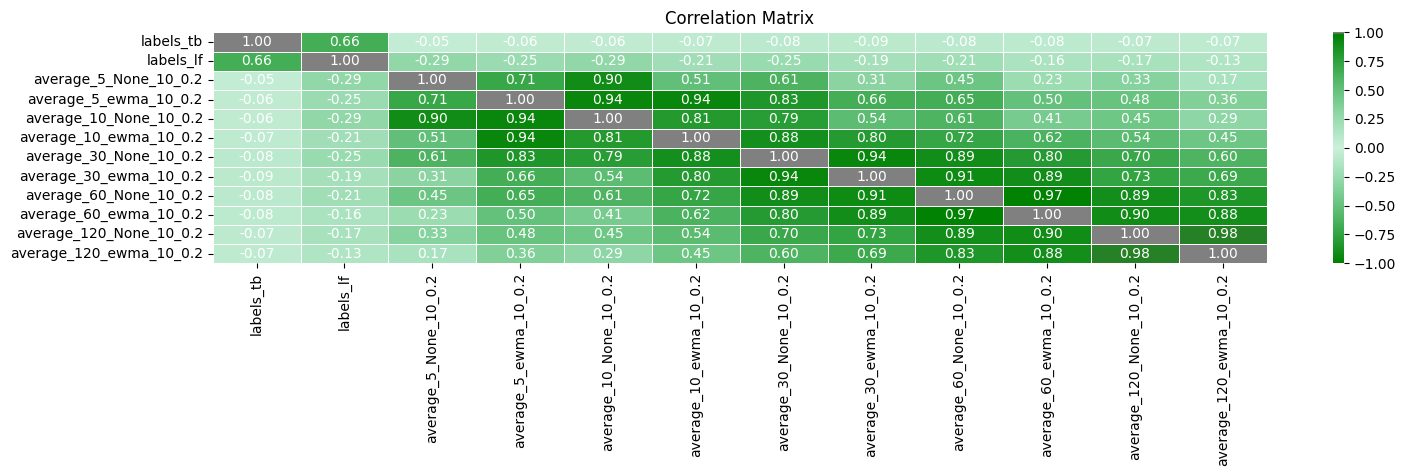

Correlation Matrix of Labels-Features on GME


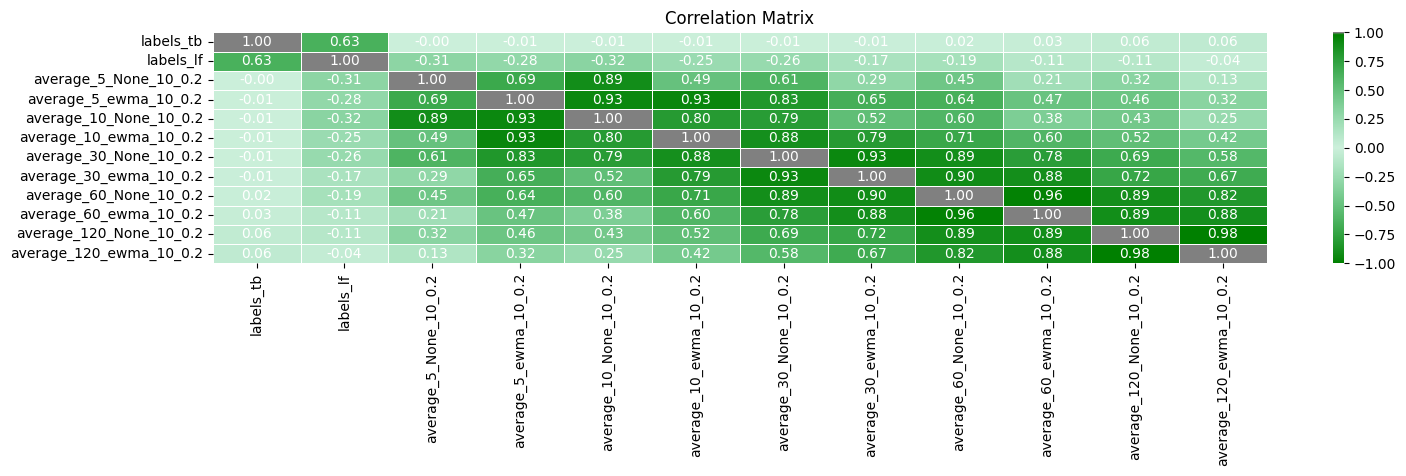

Correlation Matrix of Labels-Features on A


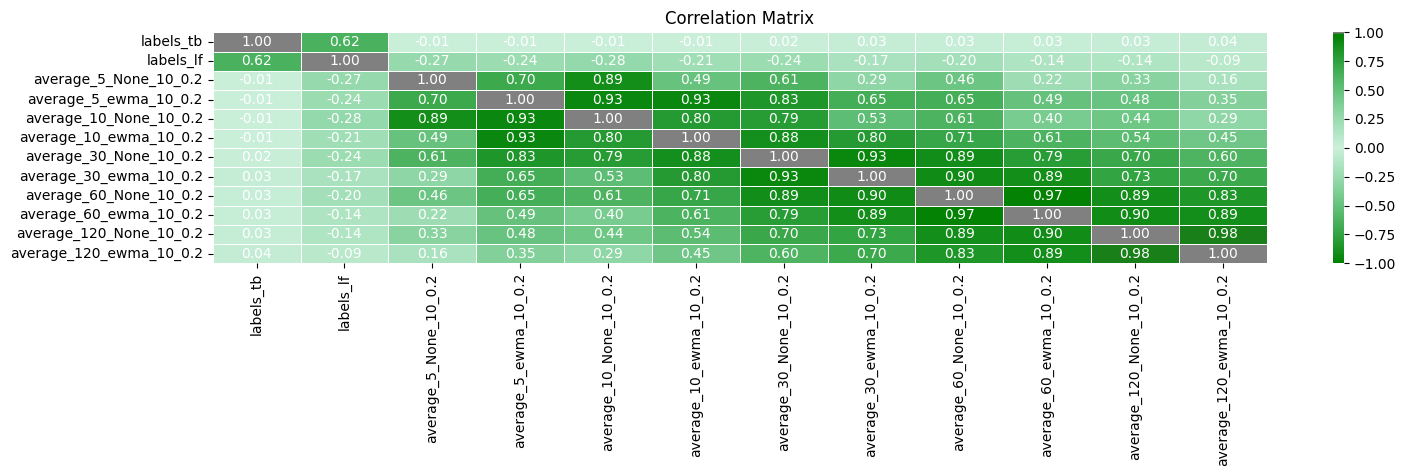

In [8]:
# Let's see the correlation matrix of the features with the labels
features_list = ['labels_tb', 'labels_lf'] + list(label_features_training['AAPL'].columns[:10])

print('Correlation Matrix of Labels-Features on AAPl')
lib.features_correlation(label_features_training['AAPL'][features_list])

print('Correlation Matrix of Labels-Features on GME')
lib.features_correlation(label_features_training['GME'][features_list])

print('Correlation Matrix of Labels-Features on A')
lib.features_correlation(label_features_training['A'][features_list])

## Interpreting the Correlation Matrices  

While the correlation matrices displayed here may not fully capture the exact amount of information provided by each feature (Pearson's correlation focuses only on linear relation), they still offer useful insights.  

Notably, since most of the features used here fall under the "momentum" category, they appear to perform better with the look-forward labeller. This is expected, as the look-forward labeller produces a less sensitive labeling, making it more aligned with momentum-based signals.  


Data Type: float64
Missing Values: 5, Unique Values: 3518
Zero Values: 0, Negative Values: 2000, Positive Values: 1518


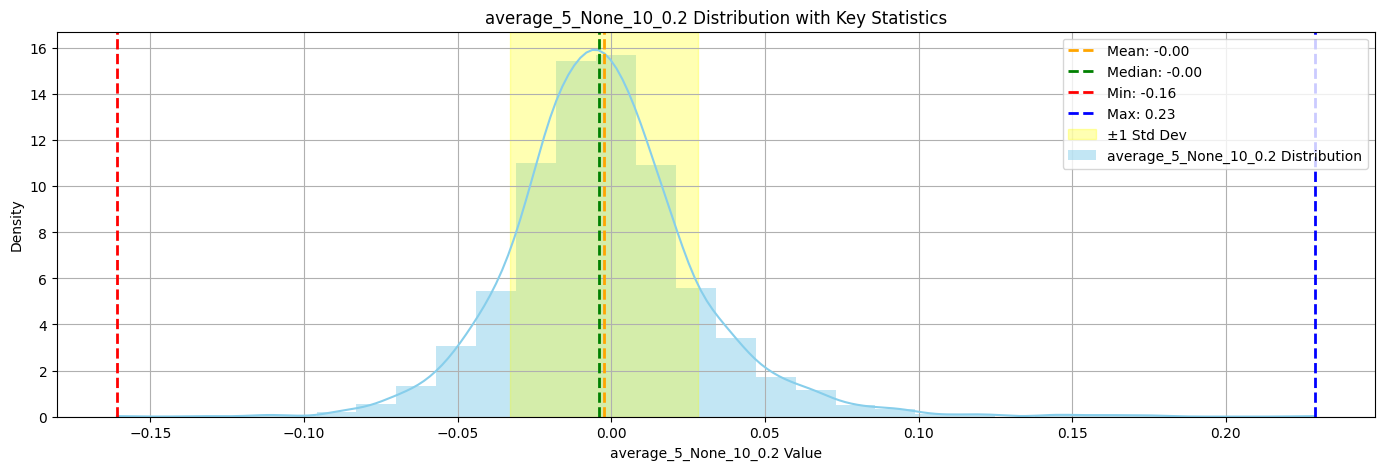

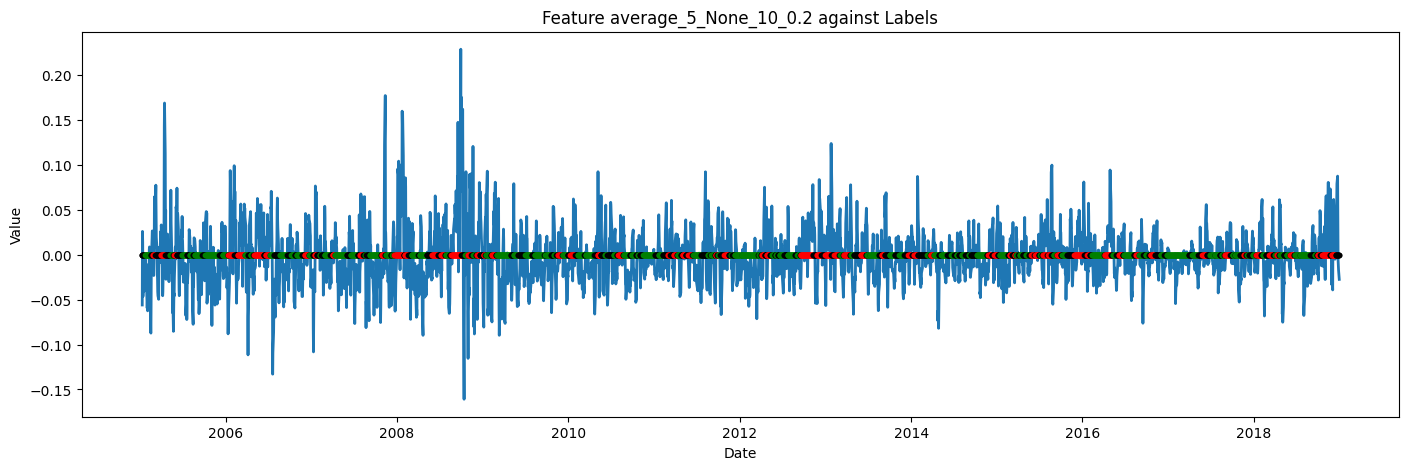

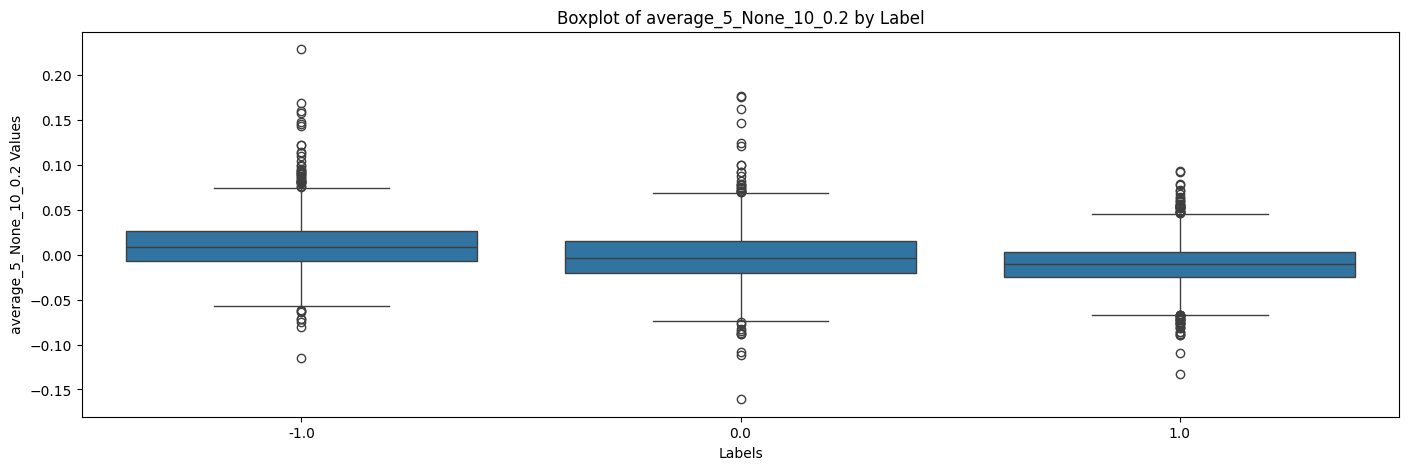

In [9]:
# Let's plot one feature to get some insights
average_5_feature = label_features_training['AAPL']['average_5_None_10_0.2']
labels_lf = label_features_training['AAPL']['labels_lf']

lib.feature_data(feature_series=average_5_feature)
lib.feature_distribution(feature_series=average_5_feature, feature_name='average_5_None_10_0.2')
lib.feature_plot(feature_series=average_5_feature, label_series=labels_lf, feature_name='average_5_None_10_0.2')

## **Feature Analysis Summary**

Our quick feature analysis reveals that the **Look Forward labelling method** yields significantly better correlations compared to the **Triple Barrier method**. This result is expected, as most of the selected features primarily capture **momentum effects**. Consequently, it makes sense that they provide a better explanation for a labelling approach designed to identify momentum periods.

### Key Observations
- Not all features exhibit the same level of explanatory power.
- Increasing the **window size** tends to reduce the effectiveness of features.
- This supports the hypothesis of **near-market efficiency**, where information is rapidly absorbed by the market, rendering older data less impactful.

These findings emphasize the importance of selecting an appropriate labelling method and optimizing window sizes to maximize feature relevance.

---
## **IV. Predictive Model**

In this section, we will train a Machine Learning model to assess the predictive power of our features and labels. The objective is to evaluate whether our dataset enables strong predictive performance and provides meaningful insights.

### **Model Selection**
We will explore different classification models, balancing interpretability and predictive accuracy. The selected models include:

- **Decision Tree** – A simple yet powerful non-linear model.
- **Logistic Regression** – A straightforward and effective baseline.
- **Random Forest** – A robust ensemble method offering improved performance and interpretability.


In [10]:
"""
First, we will prepare the data for training the model using vertical stacking.
Using vertical stacking let the model see more patterns and generalize better.
"""
training_stacked_data = pd.concat([label_features_training[ticker] for ticker in training_data.keys()], axis=0, ignore_index=True)
training_stacked_data = training_stacked_data.drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2'])
training_stacked_data = training_stacked_data.dropna(axis=0)

X_train_ = training_stacked_data.drop(['labels_tb', 'labels_lf'], axis=1)
y_train_tb = training_stacked_data['labels_tb']
y_train_lf = training_stacked_data['labels_lf']

# We drop some features that are not stable enough
training_set = {
    'AAPL': label_features_training['AAPL'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'GME': label_features_training['GME'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'A': label_features_training['A'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'META': label_features_training['META'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
}

testing_set = {
    'AAPL': label_features_testing['AAPL'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'GME': label_features_testing['GME'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'A': label_features_testing['A'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
    'META': label_features_testing['META'].drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2']).dropna(axis=0),
}

## **🌳 First Insights with a Decision Tree**

Before integrating the models into a strategy, we start with a simple **decision tree** to gain initial insights.  

> ⚠ **Note:** All models used here are implemented from scratch. As a result, the performance and efficiency may differ from existing libraries.  


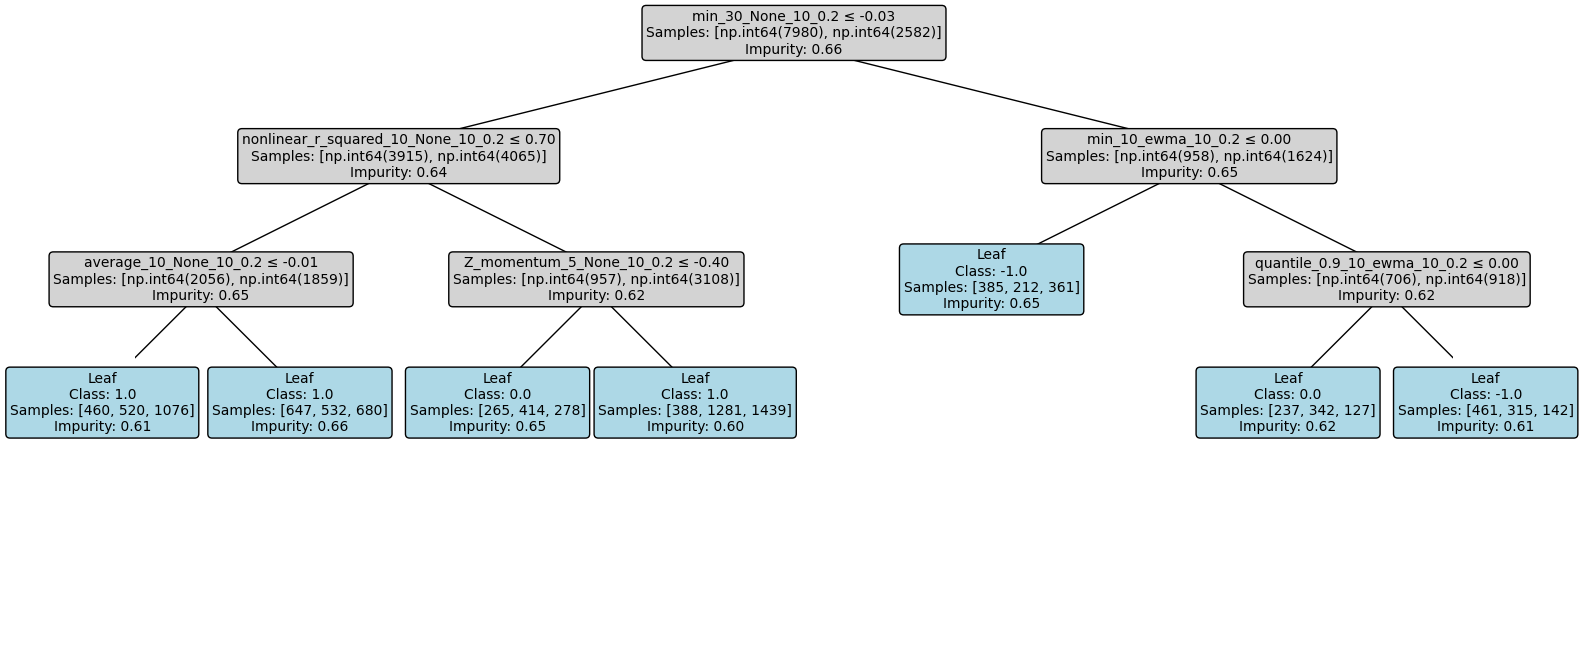

In [11]:
criterion = 'gini'
max_depth = 3
min_samples_split = 1000
min_samples_leaf = 500
max_features = 10
n_jobs = 9

decision_tree = lib.DecisionTreeClassifier(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, n_jobs=n_jobs)
decision_tree.fit(X_train_, y_train_lf)
lib.plot_tree(decision_tree.root, feature_names=X_train_.columns.tolist())

Model Performance on Training Data:


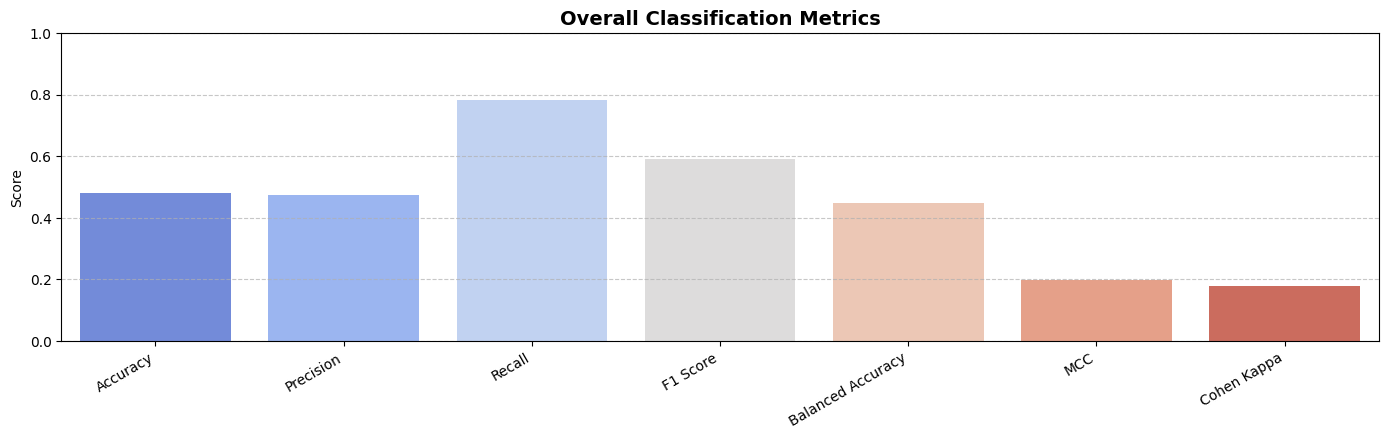

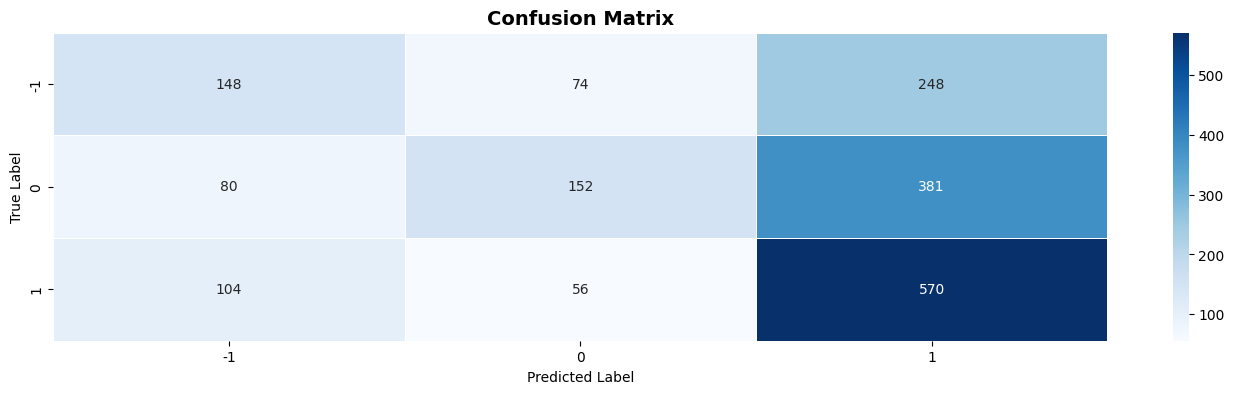

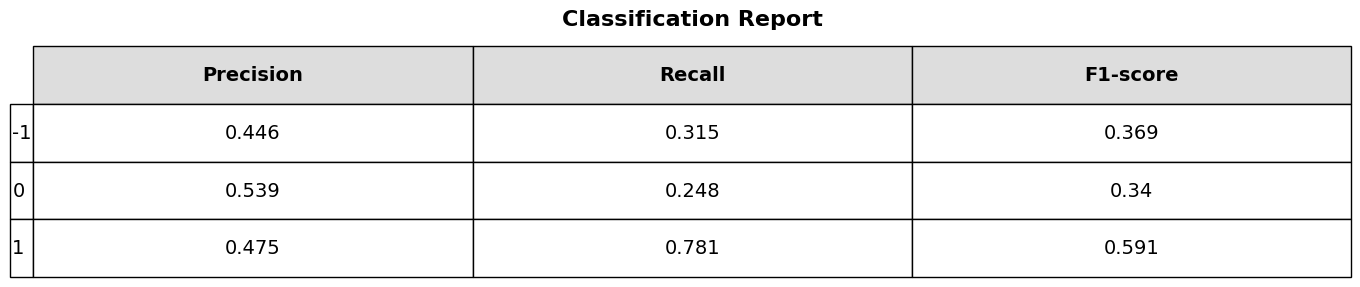

In [12]:
"""Let's see how the model performs on the training set"""
predictions = decision_tree.predict(training_set['AAPL'].drop(['labels_tb', 'labels_lf'], axis=1))
training_set['AAPL']['predictions'] = predictions
training_data['AAPL'].loc[:, 'predictions'] = training_set['AAPL']['predictions']

plotting_data = training_data['AAPL'].copy().dropna(axis=0)
plotting_data['asset_returns'] = plotting_data['close'].pct_change()
plotting_data['model_returns'] = plotting_data['predictions'] * plotting_data['asset_returns'].shift(-1)
plotting_data['model_cumret'] = (1 + plotting_data['model_returns']).cumprod()
plotting_data['asset_cumret'] = (1 + plotting_data['asset_returns']).cumprod()

print('Model Performance on Training Data:')
lib.classification_metrics(predictions=plotting_data['predictions'], labels=plotting_data['labels_lf'], classes=[-1, 0, 1])

Financial Performance on Training Data:


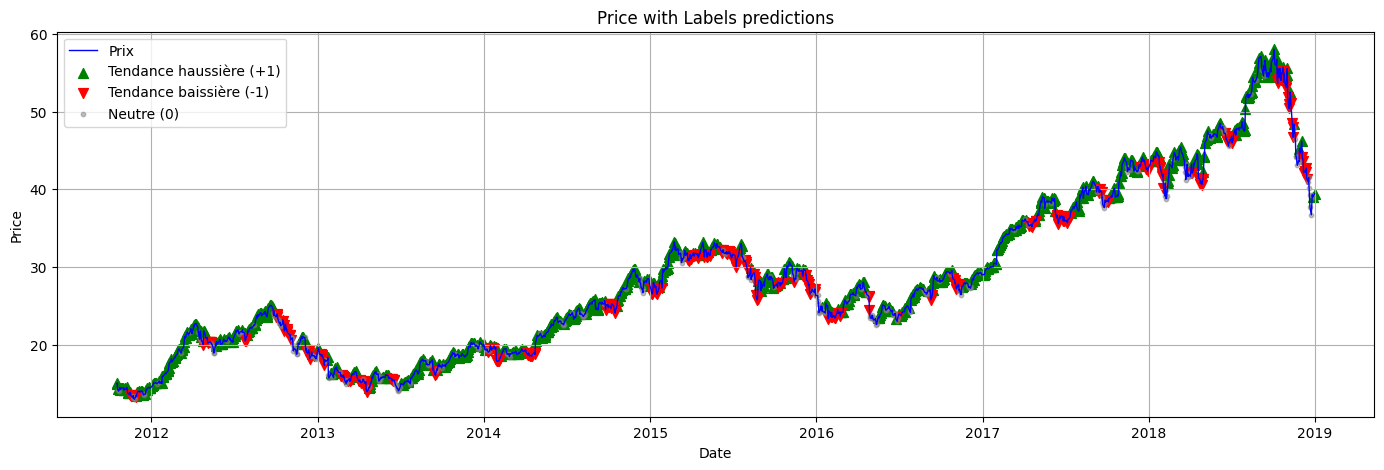

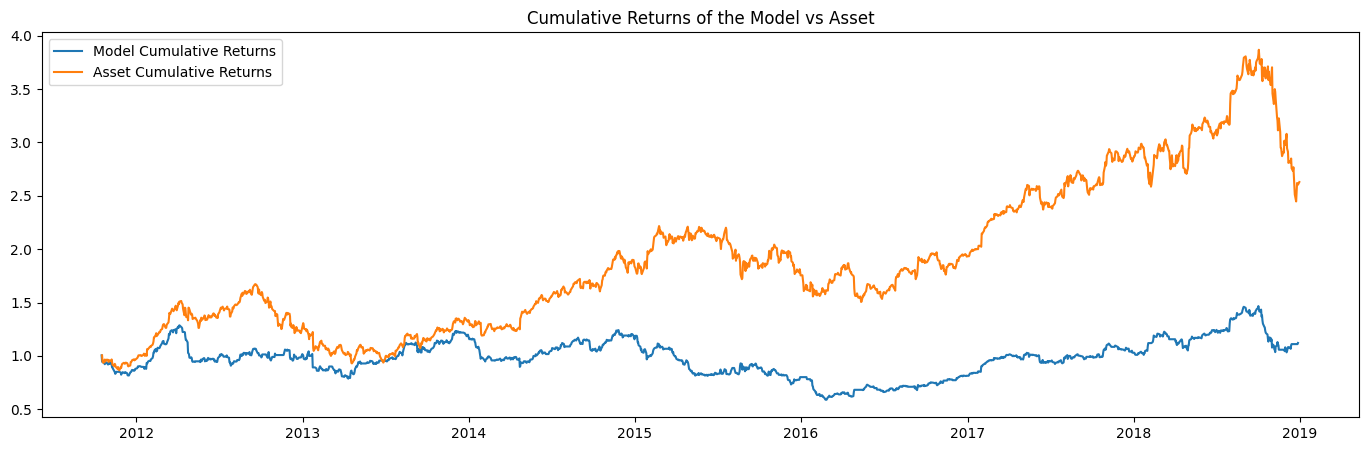

Sharpe Ratio: 0.18430324377374385, Calmar Ratio: 0.07665371283991591, Information Ratio: -0.3732528211031736


In [13]:
print('Financial Performance on Training Data:')
lib.plot_price_with_labels(plotting_data['close'], plotting_data['predictions'])
plt.figure(figsize=(17, 5))
plt.plot(plotting_data['model_cumret'], label='Model Cumulative Returns')
plt.plot(plotting_data['asset_cumret'], label='Asset Cumulative Returns')
plt.legend()
plt.title('Cumulative Returns of the Model vs Asset')
plt.show()

performance_stats, _ = lib.get_performance_measures(returns_series=plotting_data['model_returns'], market_returns=plotting_data['asset_returns'])
print(f'Sharpe Ratio: {performance_stats["sharpe_ratio"]}, Calmar Ratio: {performance_stats["calmar_ratio"]}, Information Ratio: {performance_stats["information_ratio"]}')

Model Performance on Testing Data:


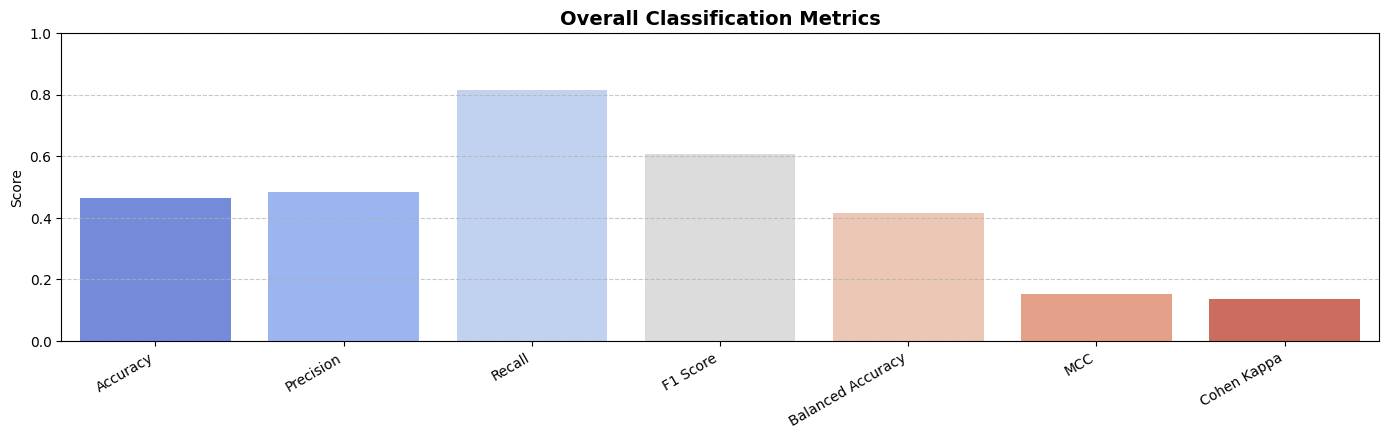

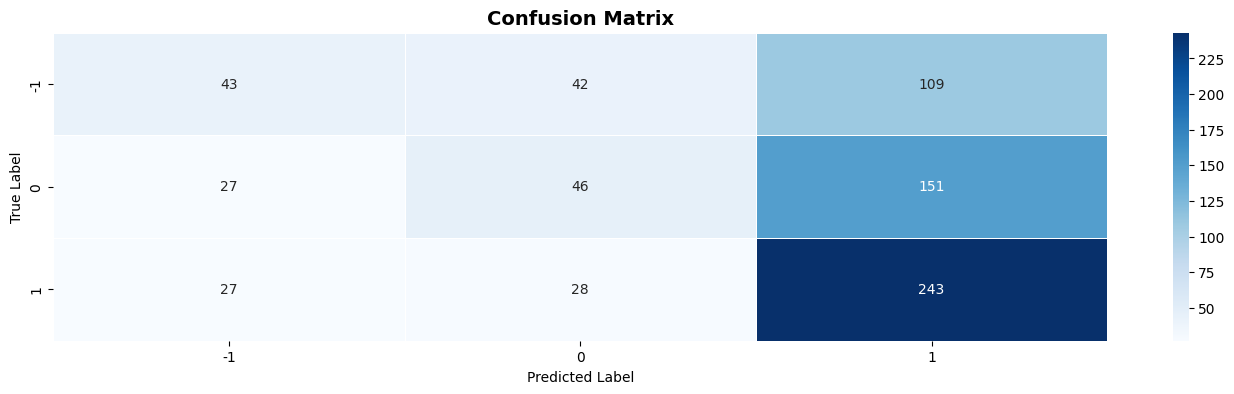

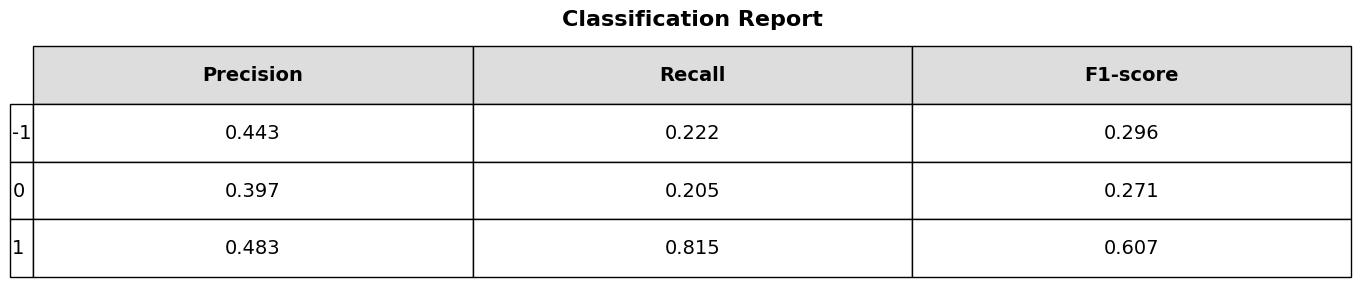

In [14]:
predictions = decision_tree.predict(testing_set['AAPL'].drop(['labels_tb', 'labels_lf'], axis=1))
testing_set['AAPL']['predictions'] = predictions
testing_data['AAPL'].loc[:, 'predictions'] = testing_set['AAPL']['predictions']

plotting_data = testing_data['AAPL'].copy().dropna(axis=0)
plotting_data['asset_returns'] = plotting_data['close'].pct_change()
plotting_data['model_returns'] = plotting_data['predictions'] * plotting_data['asset_returns'].shift(-1)
plotting_data['model_cumret'] = (1 + plotting_data['model_returns']).cumprod()
plotting_data['asset_cumret'] = (1 + plotting_data['asset_returns']).cumprod()

print('Model Performance on Testing Data:')
lib.classification_metrics(predictions=plotting_data['predictions'], labels=plotting_data['labels_lf'], classes=[-1, 0, 1])

Financial Performance on Testing Data:


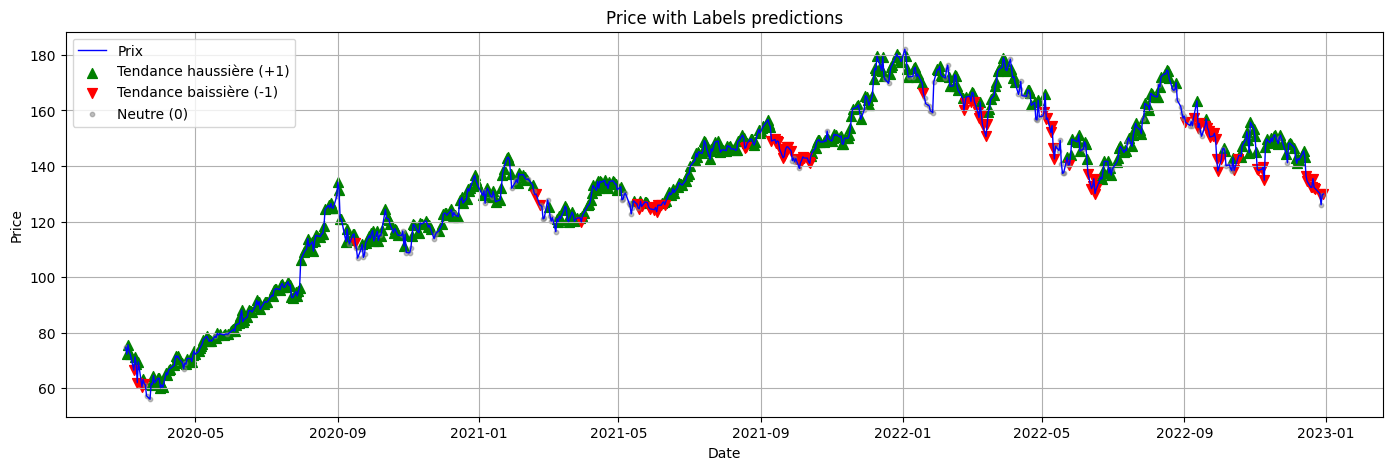

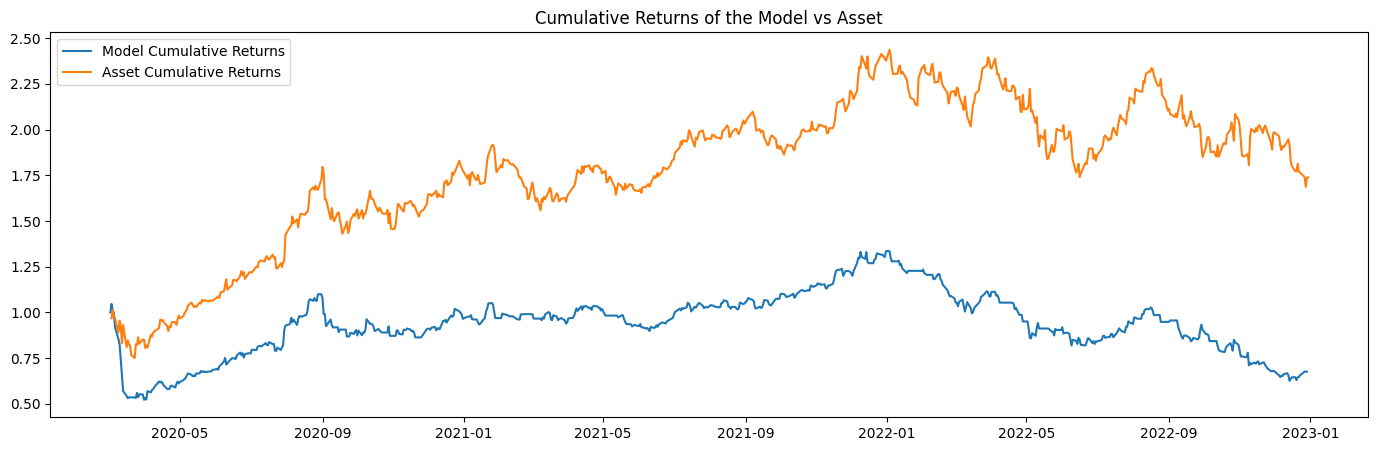

Sharpe Ratio: -0.24505473098584485, Calmar Ratio: -0.1537870108022766, Information Ratio: -0.6859952087056748


In [15]:
print('Financial Performance on Testing Data:')
lib.plot_price_with_labels(plotting_data['close'], plotting_data['predictions'])
plt.figure(figsize=(17, 5))
plt.plot(plotting_data['model_cumret'], label='Model Cumulative Returns')
plt.plot(plotting_data['asset_cumret'], label='Asset Cumulative Returns')
plt.legend()
plt.title('Cumulative Returns of the Model vs Asset')
plt.show()

performance_stats, _ = lib.get_performance_measures(returns_series=plotting_data['model_returns'], market_returns=plotting_data['asset_returns'])
print(f'Sharpe Ratio: {performance_stats["sharpe_ratio"]}, Calmar Ratio: {performance_stats["calmar_ratio"]}, Information Ratio: {performance_stats["information_ratio"]}')

## 🔍 Quick Observations  

- **Classification Metrics:** The model performs well for **long positions**, but struggles with **neutral and short positions**. This is expected, as AAPL has mostly been in a bull market, making the probability of correctly predicting `1` (long) higher.  

- **Financial Metrics:** The model **suffers significantly from its short positions**, leading to substantial underperformance compared to the underlying asset.  


---
## **🚀 Implementing a Flexible Strategy with Model Switching**

Now, let's design a robust strategy that allows us to seamlessly switch between different models. This will enable us to compare performance, optimize results, and adapt dynamically to different market conditions.  


In [16]:
class ML_Predicitons(lib.Strategy):
    def __init__(self):
        super().__init__()

        # ======= Labelling Model =======
        self.labeller = None
        self.labeller_params = None

        # ======= Features Parameters =======
        self.params_general = None
        self.params_quantile = None
        self.params_hurst = None
        self.n_jobs = None

        # ======= Predictive Model =======
        self.model = None
        self.features_list = None
    
    #*____________________________________________________________________________________ #
    def set_params(self, model, labeller, labeller_params: dict, params_general: dict, params_quantile: dict, params_hurst: dict, n_jobs: int):
        # ======= Labelling Parameters =======
        self.labeller = labeller
        self.labeller_params = labeller_params

        # ======= Features Parameters =======
        self.params_general = params_general
        self.params_quantile = params_quantile
        self.params_hurst = params_hurst
        self.n_jobs = n_jobs

        # ======= Predictive Model =======
        self.model = model
    
    #*____________________________________________________________________________________ #
    def process_data(self, data: pd.DataFrame):
        # ======= I. Extract Data ======== 
        data_df = data.copy()
        close_series = data_df['close']

        # ======== II. Apply the labeller ========
        labeller = self.labeller(data=close_series, params=self.labeller_params, n_jobs=self.n_jobs)
        labels_df = labeller.extract()
        data_df.loc[:, 'labels'] = labels_df['set_0']

        # ======= II. Extract Features ========
        average_features = lib.average_feature(data=close_series, params=params_general, n_jobs=self.n_jobs).extract()
        minimum_features = lib.minimum_feature(data=close_series, params=params_general, n_jobs=self.n_jobs).extract()
        volatility_features = lib.volatility_feature(data=close_series, params=params_general, n_jobs=self.n_jobs).extract()
        quantile_features = lib.quantile_feature(data=close_series, params=params_quantile, n_jobs=self.n_jobs).extract()
        Z_momentum_features = lib.Z_momentum_feature(data=close_series, params=params_general, n_jobs=self.n_jobs).extract()
        nonlinear_tempreg_features = lib.nonlinear_tempReg_feature(data=close_series, params=params_general, n_jobs=self.n_jobs).extract()
        hurst_exponent_features = lib.hurst_exponent_feature(data=close_series, params=params_hurst, n_jobs=self.n_jobs).extract()

        # ======= III. Concatenate Features =======
        feature_df = pd.concat([average_features, minimum_features, volatility_features, quantile_features, Z_momentum_features, nonlinear_tempreg_features, hurst_exponent_features], axis=1)
        feature_df = feature_df.drop(columns=['nonlinear_tstat_120_None_10_0.2', 'nonlinear_pvalue_120_None_10_0.2', 'nonlinear_tstat_120_ewma_10_0.2', 'nonlinear_pvalue_120_ewma_10_0.2'])
        features_list = feature_df.columns.tolist()
        self.features_list = features_list

        full_df = pd.concat([data_df, feature_df], axis=1)

        # ======= IV. Transform to a list =======
        processed_data = [full_df]
        self.processed_data = processed_data
        
        return processed_data
    
    #*____________________________________________________________________________________ #
    def fit(self, X_train: pd.DataFrame, y_train: pd.Series):
        self.model.fit(X_train, y_train)

        return self.model

    #*____________________________________________________________________________________ #
    def predict(self, df: pd.DataFrame):
        signals_df = df.copy()
        
        feature_df = signals_df[self.features_list].copy()
        feature_df = feature_df.dropna(axis=0)

        signals = self.model.predict(feature_df)
        signals = pd.Series(signals, index=feature_df.index)
        signals_df.loc[:, 'signals'] = signals
        signals_df = signals_df.dropna(axis=0)

        return signals_df

In [17]:
"""
As we modified the data in the previous sections, we will reload them so we see how the strategy class works with the new data.
"""
data = dt.load_dataList(ticker_list=['A', 'AAPL', 'GME', 'META'])

training_data = {}
testing_data = {}
embargo_data = {}

for ticker in data.keys():
    full_df = data[ticker]
    training_data[ticker] = full_df.loc['2005-01-01':'2019-01-01']
    testing_data[ticker] = full_df.loc['2019-01-01': '2023-01-01']
    embargo_data[ticker] = full_df.loc['2023-01-01':]

In [18]:
"""Let's set up the parameters"""
# I. Labelling Parameters
labeller = lib.lookForward_labeller
labeller_params = {
    "window_lookForward": [10],
    "min_trend_size": [5],
    "volatility_threshold": [1],
    "smoothing_method": ["ewma"],
    "window_smooth": [5],
    "lambda_smooth": [0.2],
}

# II. Features Parameters
params_general = {
    "window": [5, 10, 30, 60, 120],
    "smoothing_method": [None, "ewma"],
    "window_smooth": [10],
    "lambda_smooth": [0.2],
}
params_quantile = params_general.copy()
params_quantile["quantile"] = [0.1, 0.9]
params_hurst = params_general.copy()
del params_hurst["window"]
params_hurst["power"] = [3, 4, 5]

## **I. Proper Backtest with a Decision Tree**

In [19]:
"""Initialize the strategy class and create the data to train the model"""
# III. Predictive Model Parameters
model = lib.DecisionTreeClassifier(
    criterion='gini', 
    max_depth=3, 
    min_samples_split=1000, 
    min_samples_leaf=500, 
    max_features=10, 
    n_jobs=9
)

strategy = ML_Predicitons()
strategy.set_params(
    model=model, 
    labeller=labeller, 
    labeller_params=labeller_params, 
    params_general=params_general, 
    params_quantile=params_quantile, 
    params_hurst=params_hurst,
    n_jobs=9
)

training_data_list = []
for ticker, asset_df in training_data.items():
    processed_df = strategy.process_data(asset_df)
    training_data_list.append(processed_df[0])

training_df = pd.concat(training_data_list, axis=0, ignore_index=True)
training_df = training_df.drop(columns=['count_trx'])
training_df = training_df.dropna(axis=0)

X_train = training_df.drop(['labels', 'code', 'exchange', 'open', 'high', 'low', 'close', 'volume'], axis=1)
y_train = training_df['labels']

/home/mathis/Code/QuantExperiments/notebooks/../Mini_lib/Models/common.py:84: RuntimeWarning: divide by zero encountered in divide
  t_stats = coefficients / se_coefficients
/home/mathis/Code/QuantExperiments/notebooks/../Mini_lib/Models/common.py:84: RuntimeWarning: divide by zero encountered in divide
  t_stats = coefficients / se_coefficients


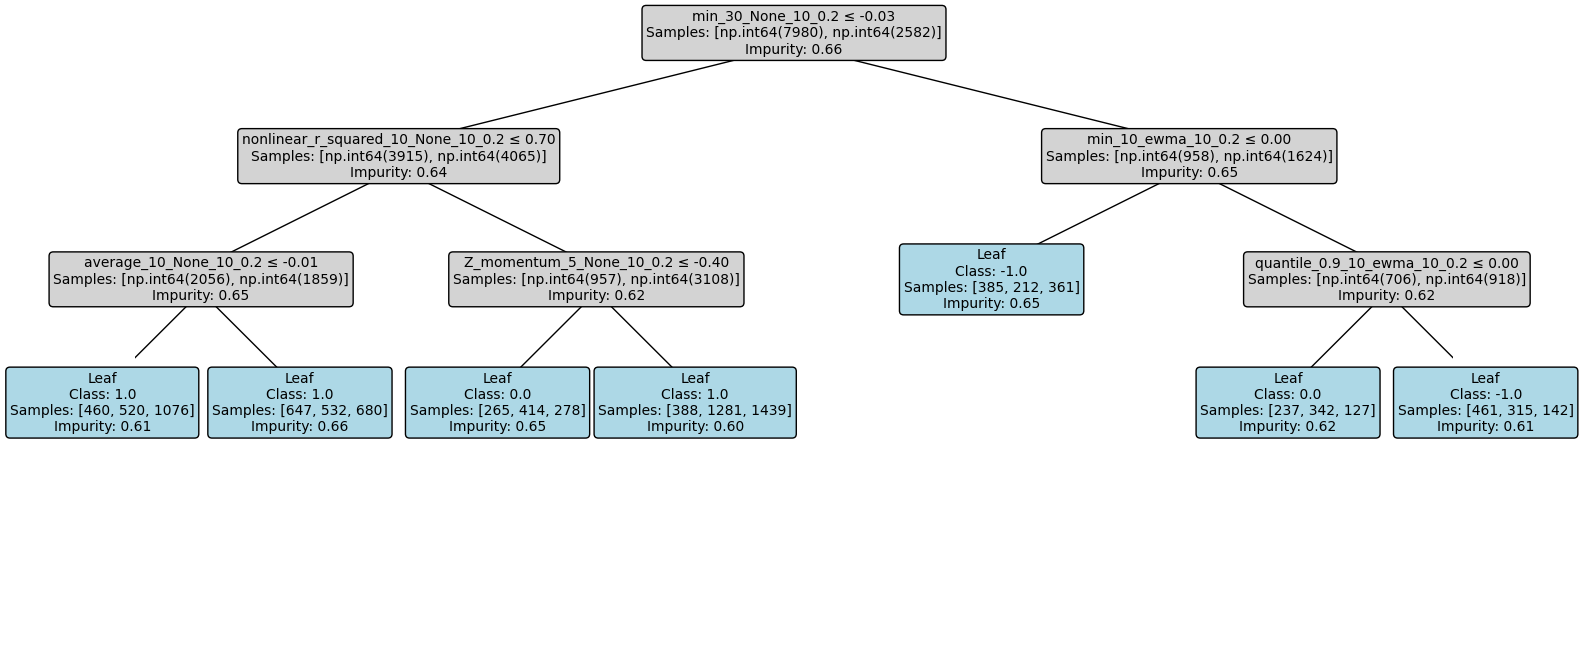

In [20]:
model = strategy.fit(X_train, y_train)
lib.plot_tree(model.root, feature_names=X_train.columns.tolist())

In [21]:
testing_asset = testing_data['AAPL'].drop(columns=['count_trx']).reset_index()
processed_asset = strategy.process_data(testing_asset)
signals_df = strategy.predict(processed_asset[0])
operations_df, _ = strategy.operate(processed_asset[0])
operations_df

,ID,Side,Entry_Date,Entry_Price,Exit_Date,Exit_Price,PnL
0,0,1,2020-03-04,74.1100,2020-03-10,69.2850,-4.8250
1,1,-1,2020-03-10,69.2850,2020-03-11,69.3475,-0.0625
2,2,1,2020-03-11,69.3475,2020-03-13,66.2225,-3.1250
3,3,-1,2020-03-13,66.2225,2020-03-16,60.4875,5.7350
4,4,1,2020-03-16,60.4875,2020-03-17,61.8775,1.3900
...,...,...,...,...,...,...,...
91,91,-1,2022-11-04,142.0900,2022-11-11,145.8200,-3.7300
92,92,1,2022-11-11,145.8200,2022-11-23,149.4500,3.6300
93,93,1,2022-11-25,148.3050,2022-11-30,141.3950,-6.9100
94,94,1,2022-12-01,148.2100,2022-12-16,136.6850,-11.5250


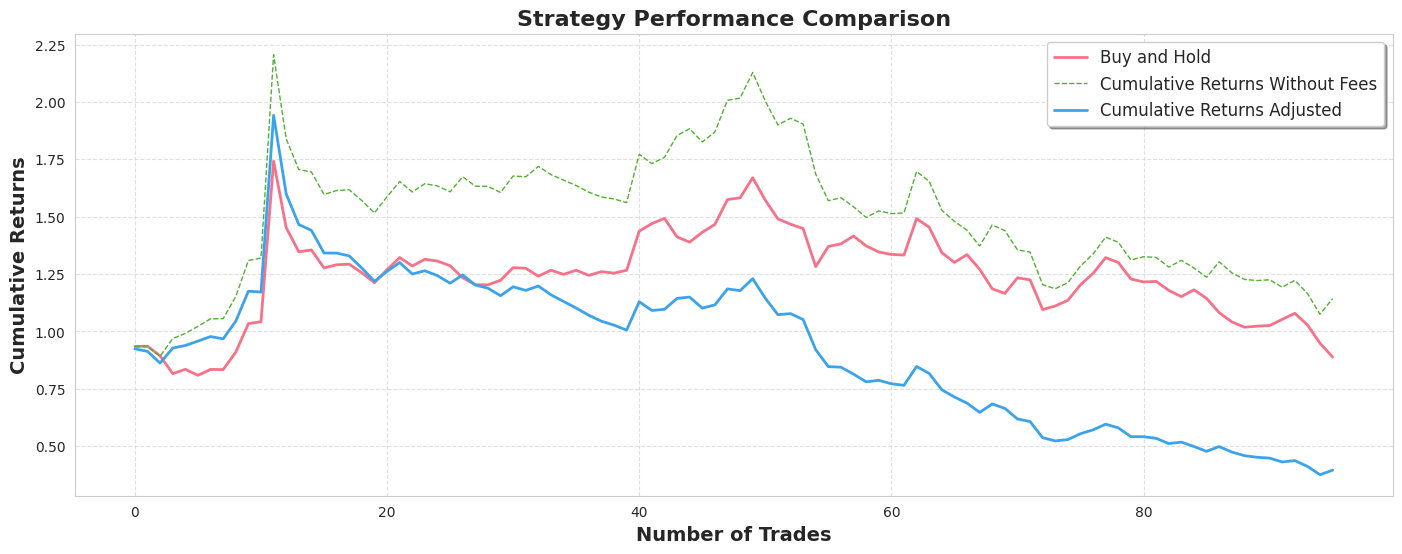

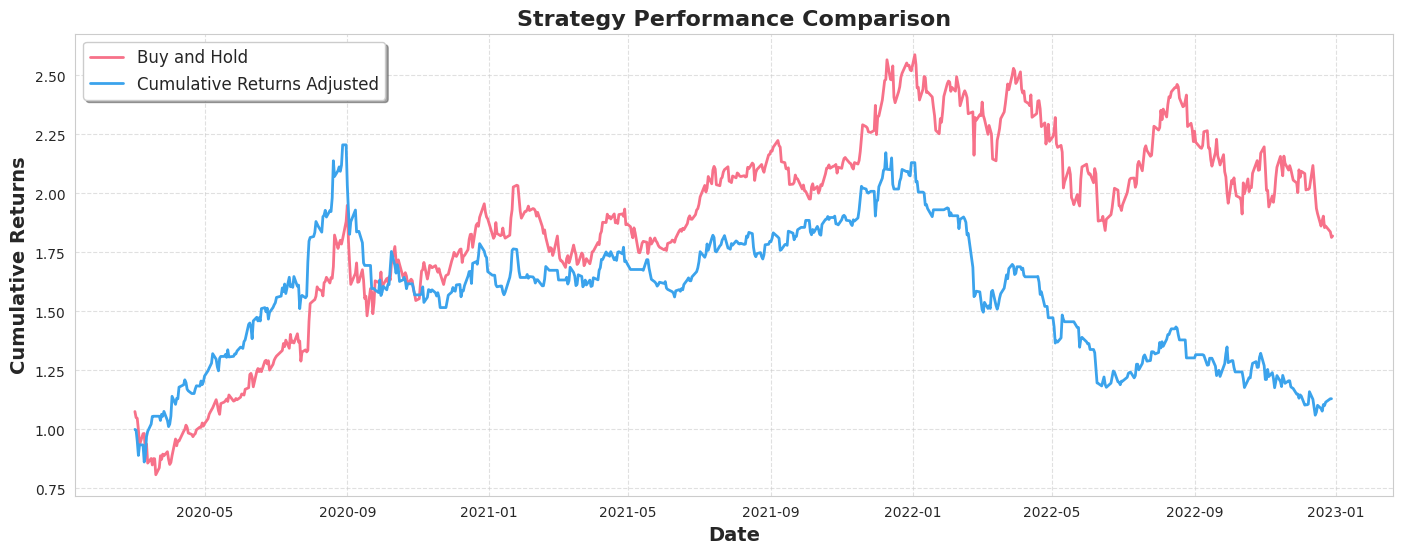

In [22]:
strategy_params = {
    'model': model,
    'labeller': labeller,
    'labeller_params': labeller_params,
    'params_general': params_general,
    'params_quantile': params_quantile,
    'params_hurst': params_hurst,
    'n_jobs': 9
}

backtester = lib.Backtest(strategy=strategy)
backtester.set_computingParams(date_name="date", bid_open_name="open", ask_open_name="open", n_jobs=1)
backtester.set_backtestParams(strategy_params=strategy_params, brokerage_cost=0.001, slippage_cost=0.005)

full_operations_df, full_signals_df = backtester.run_backtest(data=testing_asset)
performance_stats_ops = backtester.plot_operationsBars(by_date=False, BuyAndHold=True, NoFees=True, Fees=True)
performance_stats_time = backtester.plot_timeBars()

## **II. Proper Backtest with a Logistic Regression**

## **III. Proper Backtest with a Random Forest**